# Proccess Samples
This script takes raw measurement data, and spits out a "master data" spreadsheet with all data organized and including both raw and dip-adjusted depths

## Import Packages

In [1]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
from collections import OrderedDict 

# math
from scipy.stats import pearsonr


# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM
from ECMclass import core_section

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Setup

In [2]:
# Set filepaths

path_to_data = '../../data/'
path_to_figures = '../../../figures/'

## Load Dip Data

In [3]:
angles = pd.read_csv(path_to_data + 'angles/angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


## Make some functions

In [4]:
# preform dip adjustment
def dip_adjust(angles,data):

    # Add 'top_angle' and 'side_angle' columns to data
    data['top_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'top_angle'].values[0]
    )
    data['side_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'side_angle'].values[0]
    )

    print("Mapped Angles")

    # make new depth columns
    data['top_depth_adj'] = data['top_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted top depth")
    data['bottom_depth_adj'] = data['bottom_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted bottom depth")
    data['mid_depth_adj'] = data['mid_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted mid depth")

    return (data)

In [5]:
# simple before/after plot
def simple_plot(data,prox,path_to_figures,dtype,oneline=True):

    print("Oneline is " + str(oneline))

    # pull out unique values in data['section']
    sections = data['section'].unique()

    # make a set of colors for plot lines using colormap
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(len(data['stick'].unique()))]

    # make a plot for each core section
    for sec in sections:
        print("Plotting section " + str(sec))

        # filter for data in section
        df_sec = data.loc[data['section'] == sec]

        # new figure
        fig, ax = plt.subplots(len(prox), 2, figsize=(7, 2.5*len(prox)), dpi = 100, sharex=True)
        fig.suptitle('Section ' + str(sec))


        # new row for each proxy
        for i in range(len(prox)):
            print("    Plotting proxy " + prox[i])

            # filter for rows where this proxy does not contain NaN
            df_prox = df_sec.loc[~df_sec[prox[i]].isna()]

            # pull out data for this stick
            sticks = df_prox['stick'].unique()

            # new line for each stick
            for j in range(len(sticks)):

                print("        Plotting stick " + str(sticks[j]))


                stick = sticks[j]

                # set label
                label = stick

                # pull out data for this stick
                df = df_prox.loc[df_sec['stick'] == stick]

                if len(df) == 0:
                    break
                
                if oneline:

                    # plot the data
                    ax[i,0].plot(
                        df['mid_depth'], 
                        df[prox[i]], 
                        color=colors[j],
                        label=label
                    )
                    ax[i,1].plot(
                        df['mid_depth_adj'], 
                        df[prox[i]], 
                        color=colors[j],
                        label=label
                    )

                    # for each data point, plot a line from 'top_depth' to 'bottom_depth' at the df[prox[i]] value
                    for k in range(len(df)):
                        ax[i,0].plot([df['top_depth'].iloc[k], df['bottom_depth'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)
                        ax[i,1].plot([df['top_depth_adj'].iloc[k], df['bottom_depth_adj'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)

                else:

                    # for each unique combination of effective_center_x and effective_center_y, plot a line
                    for x in df['effective_center_x'].unique():
                        for y in df['effective_center_y'].unique():

                            df_xy = df.loc[(df['effective_center_x'] == x) & (df['effective_center_y'] == y)]

                            if len(df_xy) == 0:
                                continue

                                                # plot the data

                            ax[i,0].plot(
                                df_xy['mid_depth'], 
                                df_xy[prox[i]], 
                                color=colors[j],
                                label=label
                            )
                            ax[i,1].plot(
                                df_xy['mid_depth_adj'], 
                                df_xy[prox[i]], 
                                color=colors[j],
                                label=label
                            )

                            label = '__nolegend__'

                # add labels
                ax[i,0].set_ylabel(prox[i])
                ax[i,1].set_ylabel(prox[i])
                ax[i,0].set_xlabel('Depth (m)')
                ax[i,1].set_xlabel('Depth (m)')
                ax[i,0].set_title(prox[i]+' - Before Dip Adjustment')
                ax[i,1].set_title(prox[i]+' - After Dip Adjustment')

                # add legend
                # handles, labels = ax.get_legend_handles_labels()
                # handle_list, label_list = [], []
                # for handle, label in zip(handles, labels):
                #     if label not in label_list:
                #         handle_list.append(handle)
                #         label_list.append(label)
                # plt.legend(handle_list, label_list)
                ax[i,0].legend(fontsize=8, loc='upper right')
                ax[i,1].legend(fontsize=8, loc='upper right')

        plt.tight_layout()
        fig.show()
        
        fig.savefig(path_to_figures + 'initial_dip_adjustment/' + dtype+'-'+ str(sec) + '.png', dpi=300)
                



## ECM

Here I load the ECM data and store it into a single df, with both raw and dip-adjusted depths. I use 'stick' as a placeholder for the 'face'

In [6]:
# Load metadata
meta = pd.read_csv(path_to_data + 'ecm/metadata.csv')
meta.head()

# set smoothing window
window = 10

# Load ECM data
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/raw/')
    print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
    
    data_item.rem_ends(15)
    data_item.smooth(window)
    data.append(data_item)
    
    cores.append(core)
    sections.append(section)
    faces.append(face)
    ACorDCs.append(ACorDC)

# Put ECM data into core_section structure

s228_4_AC = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s230_4_AC = core_section('230_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s228_4_DC = core_section('228_4','alhic1901','DC',data,sections,faces,cores,ACorDCs)
s230_4_DC = core_section('230_4','alhic1901','DC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4_AC,s230_4_AC,s228_4_DC,s230_4_DC]:
    s.add_3d_coords()

# mannually adjust the opposite face y-axis measurement and adjust depth
o_d_adjust = 155.12
for s in [s228_4_AC,s228_4_DC]:
    s.opposite.y_s = s.opposite.y_s - 10
    s.opposite.depth_s = s.opposite.depth_s + o_d_adjust
    s.opposite.depth = s.opposite.depth + o_d_adjust

Processing data:   7%|▋         | 1/14 [00:00<00:02,  4.72it/s]

Reading alhic1901, section 230_4-t-DC
Reading alhic1901, section 230_4-l-DC
Reading alhic1901, section 228_4-t-DC


Processing data:  29%|██▊       | 4/14 [00:00<00:01,  5.52it/s]

Reading alhic1901, section 228_4-l-AC


Processing data:  36%|███▌      | 5/14 [00:00<00:01,  6.45it/s]

Reading alhic1901, section 228_4-l-DC
Reading alhic1901, section 230_4-l-AC


Processing data:  43%|████▎     | 6/14 [00:01<00:01,  5.51it/s]

Reading alhic1901, section 230_4-t-AC


Processing data:  57%|█████▋    | 8/14 [00:02<00:01,  3.10it/s]

Reading alhic1901, section 230_4-r-DC
Reading alhic1901, section 230_4-r-AC


Processing data:  64%|██████▍   | 9/14 [00:02<00:01,  3.48it/s]

Reading alhic1901, section 228_4-r-DC
Reading alhic1901, section 228_4-r-AC


Processing data:  79%|███████▊  | 11/14 [00:02<00:00,  4.44it/s]

Reading alhic1901, section 228_4-t-AC


Processing data:  86%|████████▌ | 12/14 [00:03<00:00,  3.42it/s]

Reading alhic1901, section 228_4-o-AC


Processing data:  93%|█████████▎| 13/14 [00:03<00:00,  3.15it/s]

Reading alhic1901, section 228_4-o-DC


Processing data: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]

No data found for opposite face of section 230_4 in core alhic1901
No data found for opposite face of section 230_4 in core alhic1901
The 'opposite' face does not exist for this core section.
The 'opposite' face does not exist for this core section.


In [7]:
# convert core class to df
ecm_data = pd.DataFrame()
for s in [s228_4_AC,s230_4_AC,s228_4_DC,s230_4_DC]:

    s_df = s.to_df()
    ecm_data = pd.concat([ecm_data,s_df],ignore_index=True)

In [8]:
# preform dip adjustment
ecm_master = dip_adjust(angles,ecm_data)

# remove the 'top_angle' and 'side_angle' columns from the ecm_master dataframe
ecm_master = ecm_master.drop(columns=['top_angle','side_angle'])

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


Oneline is False
Plotting section 228_4
    Plotting proxy AC_ecm
        Plotting stick o
        Plotting stick t
        Plotting stick l
        Plotting stick r
    Plotting proxy DC_ecm
        Plotting stick o
        Plotting stick t
        Plotting stick l
        Plotting stick r


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_57891/3045993115.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy AC_ecm
        Plotting stick t
        Plotting stick l
        Plotting stick r
    Plotting proxy DC_ecm
        Plotting stick t
        Plotting stick l
        Plotting stick r


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_57891/3045993115.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


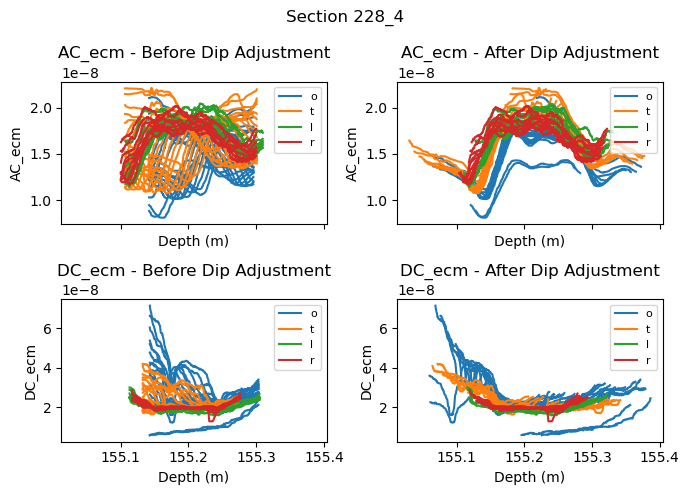

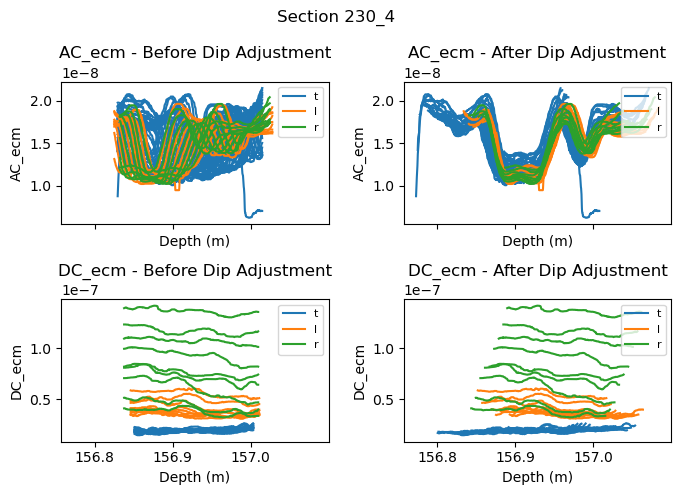

In [9]:
# Simple Plot
simple_plot(ecm_master,['AC_ecm','DC_ecm'],path_to_figures,'ECM',oneline=False)

In [10]:
def get_face_median(ecm_master,face,depth,ACorDC):

     # filter for this face
    if face != 'all':
        df = df_sec.loc[ecm_master['stick'] == face]
    else:
        df = df_sec

    # compute median value record on each face, interpolated onto the depth vector
    median_values = []
    for d in depth:

        # filter data points within 0.005 of the current depth
        nearby_points = df[(df['mid_depth_adj'] >= d - 0.0005) & (df['mid_depth_adj'] <= d + 0.0005)]

        # compute the median of AC_ecm and DC_ecm for these points
        median_values.append(nearby_points[ACorDC].median() if 'AC_ecm' in nearby_points else None)
    
    return(median_values)

Best shift for AC_ecm on section 228_4 and face l  is 0.004
Best shift for AC_ecm on section 228_4 and face r  is 0.014
Best shift for AC_ecm on section 228_4 and face o  is -0.01


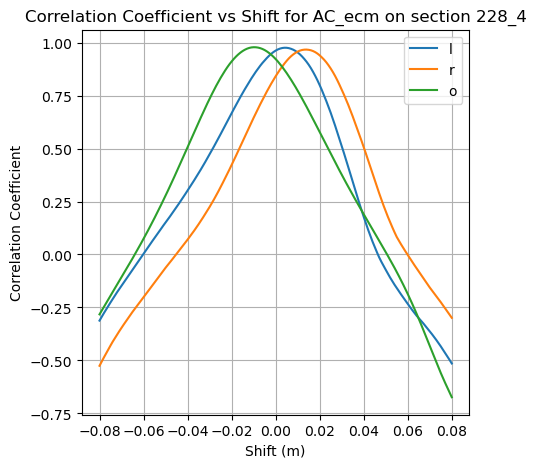

Best shift for AC_ecm on section 230_4 and face l  is -0.01
Best shift for AC_ecm on section 230_4 and face r  is -0.006


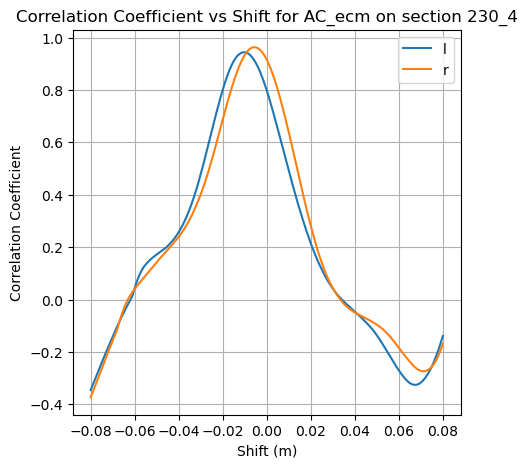

In [11]:
# Let's compute a mean ECM (dip adjusted)
shifts_df = pd.DataFrame(columns=['section','face','shift','ACorDC'])

for ACorDC in ['AC_ecm']:
    for section in ['228_4','230_4']:#ecm_master['section'].unique():

        fig,ax = plt.subplots(1, 1, figsize=(5, 5), dpi = 100)

        df_sec = ecm_master.loc[ecm_master['section'] == section]

        # make a new depth vector, at 0.01 spacing rounded to the nearest 0.005 from the min to max of the mid_depth_adj column
        depth = np.arange(
            round(df_sec['mid_depth_adj'].min(), 3),
            round(df_sec['mid_depth_adj'].max(), 3),
            0.001
        )


        t_median = get_face_median(df_sec,'t',depth,ACorDC)
        l_median = get_face_median(df_sec,'l',depth,ACorDC)
        r_median = get_face_median(df_sec,'r',depth,ACorDC)
        side_medians = [l_median,r_median]
        faces = ['l','r']

        # get face median
        if 'o' in df_sec['stick'].unique():
            o_median = get_face_median(df_sec,'o',depth,ACorDC)
            side_medians.append(o_median)
            faces.append('o')


        shift_max = 0.08
        shift = np.linspace(-shift_max,shift_max,int(shift_max*2/0.001+1))
        shift.round(3)
        for (side_median,face) in zip(side_medians,faces):

            corr_list = []

            for s in shift:

                depth_t = depth
                depth_side = depth + s

                # get index of all values which appear in both depth_t and depth_side
                common_vals = np.intersect1d(np.round(depth_t, 3), np.round(depth_side, 3))
                common_idx_t = np.where(np.isin(np.round(depth_t, 3), common_vals))[0]
                common_idx_s = np.where(np.isin(np.round(depth_side, 3), common_vals))[0]

                # get the values of depth_t and depth_side which are in common_index
                t_median_shared = np.array(t_median)[common_idx_t]
                side_median_shared = np.array(side_median)[common_idx_s]

                # get index of all values which are not NaN in t_median_shared and side_median_shared
                not_nan_index = ~np.isnan(t_median_shared) & ~np.isnan(side_median_shared)

                # get the values of t_median_shared and side_median_shared which are not NaN
                t_median_shared = t_median_shared[not_nan_index]
                side_median_shared = side_median_shared[not_nan_index]

                # compute the correlation coefficient with Pearson's method
                if len(t_median_shared) == 0 or len(side_median_shared) == 0:
                    print("No data points in common for shift " + str(s))
                    corr_list.append(np.nan)
                else:
                    corr, _ = pearsonr(t_median_shared, side_median_shared)
                    corr_list.append(corr)

            ax.plot(shift,corr_list,label=face)

            # find shift that corresponds to the maximum correlation coefficient
            max_corr = np.nanmax(corr_list)
            max_corr_idx = np.nanargmax(corr_list)
            best_shift = shift[max_corr_idx]
            print("Best shift for " + ACorDC + " on section " + section + " and face " + face +"  is " + str(round(best_shift,3)))            

            # add value to shifts_df
            if face == 'o':
                best_shift = best_shift + o_d_adjust
            new_row = pd.DataFrame({'section': section, 'face': face, 'shift': round(best_shift,6), 'ACorDC': ACorDC}, index=[0])
            shifts_df = pd.concat([shifts_df, new_row], ignore_index=True)
        
        ax.set_xlabel('Shift (m)')
        ax.set_ylabel('Correlation Coefficient')
        ax.set_title('Correlation Coefficient vs Shift for ' + ACorDC + ' on section ' + section)
        ax.legend()
        ax.grid()
        plt.show()

In [12]:
# NOT USING THIS - EASIER TO DO BELOW

# for s in [s228_4_AC,s230_4_AC]:

#     if s.top.ACorDC == 'AC':
#         ACorDC == 'AC_ecm'
#     else:
#         ACorDC == 'DC_ecm'


#     # filter for just rows in this stick
#     df_sec = ecm_master.loc[ecm_master['section'] == s.section]

#     # # STILL NEED TO APPLY THE SHIFT!!!
#     # # loop through sections in the stick
#     # for face in df_sec['stick'].unique():
#     #     if face in ['o','l','r']:

#     #         # get the shift
#     #         shift = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == face) & (shifts_df['ACorDC'] == ACorDC), 'shift'].values[0]

#     #         # apply the depth adjustment to rows of df_sec which match the 'face'
#     #         # there must be a better way to do this - but I'm on a flight and can't look it up.
#     #         idx = df_sec['stick'] == face
#     #         for d in ['top_depth','bottom_depth','mid_depth','top_depth_adj','bottom_depth_adj','mid_depth_adj']:
#     #             df_sec[d][idx] = df_sec[d][idx] + shift
                    

#     # make a new depth vector, at 0.01 spacing rounded to the nearest 0.005 from the min to max of the mid_depth_adj column
#     depth = np.arange(
#         round(df_sec['mid_depth_adj'].min(), 3),
#         round(df_sec['mid_depth_adj'].max(), 3),
#         0.001
#     )
    
#     # get face median
#     median = get_face_median(df_sec,'all',depth,'AC_ecm')

#     new_rows = pd.DataFrame({
#         'mid_depth': depth,
#         'top_depth': depth,
#         'bottom_depth': depth,
#         'top_depth_adj': depth,
#         'bottom_depth_adj': depth,
#         'mid_depth_adj': depth,
#         'AC_ecm': median,
#         'effective_center_x': [0]*len(depth),
#         'effective_center_y': [0]*len(depth),
#         'x_lo': [0]*len(depth),
#         'x_hi': [0]*len(depth),
#         'y_lo': [0]*len(depth),
#         'y_hi': [0]*len(depth),
#         'section': [s.section]*len(depth),
#         'stick': ['median']*len(depth),
#         'core': ['alhic1901']*len(depth)
#     })

#     ecm_master = pd.concat([ecm_master, new_rows], ignore_index=True)
    
# # save the ecm_master dataframe
# ecm_master.to_csv(path_to_data + 'sampling/master/ecm_master.csv', index=False)

# # save a seccond version where only columns where stick is median are kept
# ecm_master_median = ecm_master.loc[ecm_master['stick'] == 'median']
# ecm_master_median.to_csv(path_to_data + 'sampling/master/ecm_median_master.csv', index=False)

In [13]:
#re-load the ECM data, now without any end trimming
# Load metadata
meta = pd.read_csv(path_to_data + 'ecm/raw/metadata.csv')
meta.head()

# set smoothing window
window = 10

# Load ECM data
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/raw/')
    print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
    
    data.append(data_item)
    data_item.smooth(window)
    
    cores.append(core)
    sections.append(section)
    faces.append(face)
    ACorDCs.append(ACorDC)

# Put ECM data into core_section structure
s228_4_AC = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s230_4_AC = core_section('230_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s228_4_DC = core_section('228_4','alhic1901','DC',data,sections,faces,cores,ACorDCs)
s230_4_DC = core_section('230_4','alhic1901','DC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4_AC,s230_4_AC,s228_4_DC,s230_4_DC]:
    s.add_3d_coords()

# mannually adjust the opposite face y-axis measurement and adjust depth
o_d_adjust = 155.12
for s in [s228_4_AC,s228_4_DC]:
    s.opposite.y_s = s.opposite.y_s - 10


Processing data:   0%|          | 0/14 [00:00<?, ?it/s]

Reading alhic1901, section 230_4-t-DC


Processing data:  14%|█▍        | 2/14 [00:00<00:02,  5.84it/s]

Reading alhic1901, section 230_4-l-DC
Reading alhic1901, section 228_4-t-DC


Processing data:  21%|██▏       | 3/14 [00:00<00:02,  5.14it/s]

Reading alhic1901, section 228_4-l-AC


Processing data:  36%|███▌      | 5/14 [00:00<00:01,  5.60it/s]

Reading alhic1901, section 228_4-l-DC
Reading alhic1901, section 230_4-l-AC


Processing data:  43%|████▎     | 6/14 [00:01<00:01,  4.80it/s]

Reading alhic1901, section 230_4-t-AC


Processing data:  57%|█████▋    | 8/14 [00:02<00:02,  2.71it/s]

Reading alhic1901, section 230_4-r-DC
Reading alhic1901, section 230_4-r-AC


Processing data:  64%|██████▍   | 9/14 [00:02<00:01,  3.07it/s]

Reading alhic1901, section 228_4-r-DC
Reading alhic1901, section 228_4-r-AC


Processing data:  79%|███████▊  | 11/14 [00:02<00:00,  3.98it/s]

Reading alhic1901, section 228_4-t-AC


Processing data:  86%|████████▌ | 12/14 [00:03<00:00,  3.06it/s]

Reading alhic1901, section 228_4-o-AC


Processing data:  93%|█████████▎| 13/14 [00:03<00:00,  2.78it/s]

Reading alhic1901, section 228_4-o-DC


Processing data: 100%|██████████| 14/14 [00:04<00:00,  3.29it/s]

No data found for opposite face of section 230_4 in core alhic1901
No data found for opposite face of section 230_4 in core alhic1901
The 'opposite' face does not exist for this core section.
The 'opposite' face does not exist for this core section.


In [14]:

for s in [s228_4_AC,s230_4_AC]:

    # pull the correct shift value from the shift d
    shift_l = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'l') & (shifts_df['ACorDC'] == 'AC_ecm'), 'shift'].values[0]
    shift_r = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'r') & (shifts_df['ACorDC'] == 'AC_ecm'), 'shift'].values[0]

    # apply the shift to the raw ECM data
    s.left.depth_s += shift_l
    s.right.depth_s += shift_r
    s.left.depth += shift_l
    s.right.depth += shift_r

    faces = [s.left,s.right,s.top]

    # also do the same to the opposite face if it exists
    if 'o' in shifts_df[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'l') & (shifts_df['ACorDC'] == 'AC_ecm')]:
        shift_o = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'o') & (shifts_df['ACorDC'] == 'AC_ecm'), 'shift'].values[0]
        s.opposite.depth_s += shift_o
        s.opposite.depth += shift_o
        faces.append(s.opposite)
    
    # write out the file
    for face in faces:
        
        df = pd.DataFrame()
        df['Y_dimension(mm)'] = face.y
        df['Button'] = face.button
        df['True_depth(m)'] = face.depth
        df['meas'] = face.meas
        
        # save the file
        filename = path_to_data + 'ecm/alligned/' + s.core + '-' + s.section + '-' + face.face + '-' +face.ACorDC+ '.csv'
        df.to_csv(filename, index=False)

    

** Impliment Shifts **
 ** Preforming Dip Adjustment **
Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth
** Making Dataframe **
** Simple Plot **
Oneline is False
Plotting section 228_4
    Plotting proxy AC_ecm
        Plotting stick o
        Plotting stick t
        Plotting stick l
        Plotting stick r
    Plotting proxy DC_ecm
        Plotting stick o
        Plotting stick t
        Plotting stick l
        Plotting stick r


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_57891/3045993115.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy AC_ecm
        Plotting stick t
        Plotting stick l
        Plotting stick r
    Plotting proxy DC_ecm
        Plotting stick t
        Plotting stick l
        Plotting stick r


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_57891/3045993115.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


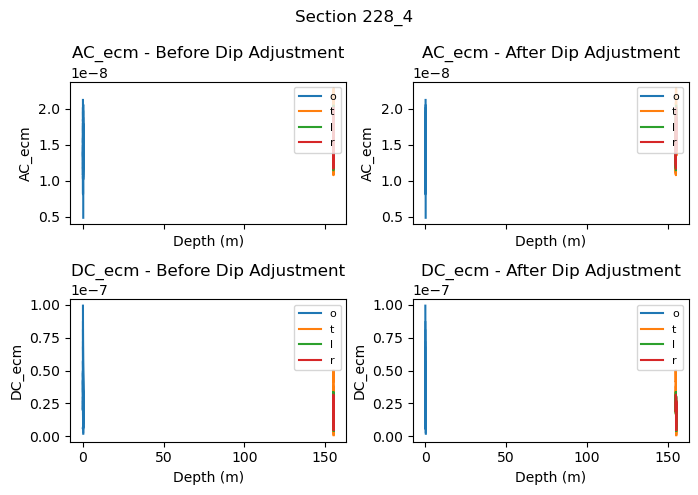

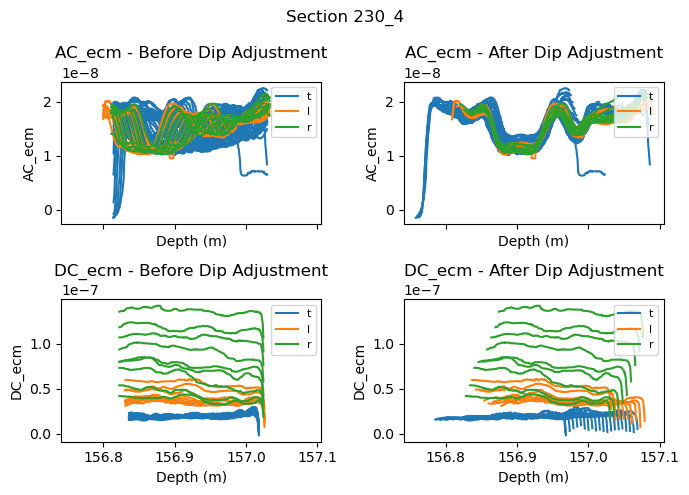

In [ ]:
# convert core class to df
print("** Impliment Shifts **")
ecm_data = pd.DataFrame()
for s in [s228_4_AC,s230_4_AC,s228_4_DC,s230_4_DC]:

    # pull the correct shift value from the shift d
    shift_l = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'l') & (shifts_df['ACorDC'] == 'AC_ecm'), 'shift'].values[0]
    shift_r = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'r') & (shifts_df['ACorDC'] == 'AC_ecm'), 'shift'].values[0]

    # apply the shift to the raw ECM data
    s.left.depth += shift_l
    s.right.depth += shift_r

    faces = [s.left,s.right,s.top]

    # also do the same to the opposite face if it exists
    if 'o' in shifts_df[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'l') & (shifts_df['ACorDC'] == 'AC_ecm')]:
        shift_o = shifts_df.loc[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'o') & (shifts_df['ACorDC'] == 'AC_ecm'), 'shift'].values[0]
        s.opposite.depth += shift_o
        faces.append(s.opposite)
        print("** confirming face shift **")

    s_df = s.to_df()
    ecm_data = pd.concat([ecm_data,s_df],ignore_index=True)

# preform dip adjustment
print("** Preforming Dip Adjustment **")
ecm_master = dip_adjust(angles,ecm_data)

# remove the 'top_angle' and 'side_angle' columns from the ecm_master dataframe
print("** Making Dataframe **")
ecm_master = ecm_master.drop(columns=['top_angle','side_angle'])

# Simple Plot
print("** Simple Plot **")
simple_plot(ecm_master,['AC_ecm','DC_ecm'],path_to_figures,'ECM',oneline=False)

In [ ]:
 shifts_df[(shifts_df['section'] == s.section) & (shifts_df['face'] == 'l') & (shifts_df['ACorDC'] == 'AC_ecm')].face[0]

3    l
Name: face, dtype: object